In [25]:
%pylab inline
import pandas as pd
import tensorflow as tf
import glob
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from tqdm import tqdm_notebook
from multiprocessing import Pool
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(42)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)
BUFFER_SIZE= 100

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pywsi.io.operations import get_annotation_bounding_boxes
from pywsi.io.operations import get_annotation_polygons
from pywsi.io.operations import path_leaf
from pywsi.io.operations import read_as_rgb
from pywsi.io.operations import WSIReader
from pywsi.io.tiling import get_all_patches_from_slide
from pywsi.io.tiling import save_images_and_mask, generate_tiles, generate_tiles_fast

from pywsi.morphology.patch_extractor import TissuePatch
from pywsi.morphology.mask import get_common_interior_polygons
from tqdm import tqdm
from multiprocessing import Pool
from pywsi.segmentation import label_nuclei, summarize_region_properties
from pywsi.deep_model.model import slide_level_map

from collections import defaultdict
import joblib
import numpy as np
from six import iteritems


Using TensorFlow backend.


In [3]:
train_samples = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented.tsv')

is_tumor_idx = list(train_samples.columns).index('is_tumor')

In [4]:
def order(frame,var):
    if type(var) is str:
        var = [var] #let the command take a string or list
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

In [5]:
# Parameters
num_steps = 500 # Total steps to train
batch_size = 1#024 # The number of samples per batch
num_classes = 2 # 2 classes
num_features = 46 # columns in the feature
num_trees = 100
max_nodes = 10000

def _parse_csv(rows_string_tensor):
        """Takes the string input tensor and returns tuple of (features, labels)."""
        # Last dim is the label.        
        num_columns = num_features + 1 
        columns = tf.decode_csv(rows_string_tensor,
                                record_defaults=[[0.0]] * num_columns , 
                                field_delim='\t')
        label = columns[0]
        print(label)
        #label = columns[is_tumor_idx]
        #stack1 = tf.stack(columns[0: is_tumor_idx])
        #stack2 = tf.stack(columns[is_tumor_idx+1:])
        #return tf.stack([columns[x0: is_tumor_idx], columns[is_tumor_idx+1:]]), tf.cast(label, tf.int32)
        return tf.cast(tf.stack(columns[1:]), tf.float32), tf.cast(label, tf.int32)
        #return  tf.cast(label, tf.int32),  tf.cast(label, tf.int32)

def input_fn(file_names, batch_size):   

    """The input_fn."""
    dataset = tf.data.TextLineDataset(file_names).skip(1)
    # Skip the first line (which does not have data).
    dataset = dataset.map(_parse_csv)
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)

    dataset = dataset.batch(batch_size)
    iterator = tf.data.Iterator.from_structure(dataset.output_types,
                                               dataset.output_shapes)
    next_batch = iterator.get_next()
    init_op = iterator.make_initializer(dataset)
    return init_op, next_batch

In [6]:
X = tf.placeholder(tf.float32, shape=[None, num_features])
# For random forest, labels must be integers (the class id)
Y = tf.placeholder(tf.int32, shape=[None])

# Random Forest Parameters
hparams = tensor_forest.ForestHParams(num_classes=num_classes,
                                      num_features=num_features,
                                      num_trees=num_trees,
                                      max_nodes=max_nodes).fill()

# Build the Random Forest
forest_graph = tensor_forest.RandomForestGraphs(hparams)
# Get training graph and loss
train_op = forest_graph.training_graph(X, Y)
loss_op = forest_graph.training_loss(X, Y)

# Measure the accuracy
infer_op, _, _ = forest_graph.inference_graph(X)
correct_prediction = tf.equal(tf.argmax(infer_op, 1), tf.cast(Y, tf.int64))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize the variables (i.e. assign their default value) and forest resources
init_vars = tf.group(tf.global_variables_initializer(),
                     resources.initialize_resources(resources.shared_resources()))

# Start TensorFlow session
sess = tf.Session()

# Run the initializer
sess.run(init_vars)

INFO:tensorflow:Constructing forest with params = 
INFO:tensorflow:{'checkpoint_stats': False, 'inference_tree_paths': False, 'num_trees': 100, 'num_features': 46, 'dominate_fraction': 0.99, 'num_splits_to_consider': 10, 'finish_type': 0, 'valid_leaf_threshold': 1, 'max_nodes': 10000, 'bagged_features': None, 'feature_bagging_fraction': 1.0, 'early_finish_check_every_samples': 0, 'regression': False, 'collate_examples': False, 'dominate_method': 'bootstrap', 'split_pruning_name': 'none', 'split_after_samples': 250, 'num_classes': 2, 'model_name': 'all_dense', 'use_running_stats_method': False, 'num_outputs': 1, 'initialize_average_splits': False, 'bagging_fraction': 1.0, 'pruning_type': 0, 'split_name': 'less_or_equal', 'max_fertile_nodes': 0, 'num_output_columns': 3, 'split_finish_name': 'basic', 'stats_model_type': 0, 'base_random_seed': 0, 'split_type': 0, 'prune_every_samples': 0, 'param_file': None, 'leaf_model_type': 0, 'bagged_num_features': 46}


In [7]:
train_samples = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented.tsv')
train_samples = train_samples.drop(columns='0')

validation_samples = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_with_mask_segmented.tsv')
validation_samples = validation_samples.drop(columns='0')


train_samples_labels = pd.read_table(
    '/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_with_mask.tsv'
)
validation_samples_labels = pd.read_table(
    '/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_with_mask.tsv'
)
train_samples = order(train_samples, ['is_tumor'])
train_samples.is_tumor = train_samples.is_tumor.astype('int32')

train_samples.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented_with_labels.tsv',
                    index=False,
                    header=True,
                    sep='\t')

validation_samples = order(validation_samples, ['is_tumor'])
validation_samples.is_tumor = validation_samples.is_tumor.astype('int32')
validation_samples.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_segmented_with_labels.tsv',
                    index=False,
                    header=True,
                    sep='\t')


# Sample only half the points
train_samples_tumor = train_samples[train_samples.is_tumor==True].sample(frac=0.45, random_state=42)
train_samples_normal = train_samples[train_samples.is_tumor==False].sample(frac=0.45, random_state=43)

validation_samples_tumor = validation_samples[validation_samples.is_tumor==True].sample(frac=0.45, random_state=42)
validation_samples_normal = validation_samples[validation_samples.is_tumor==False].sample(frac=0.45, random_state=43)


train_samples = pd.concat([train_samples_tumor, train_samples_normal]).sample(frac=1, random_state=42)
validation_samples = pd.concat([validation_samples_tumor, validation_samples_normal]).sample(frac=1, random_state=43)
train_samples = train_samples.dropna()
validation_samples = validation_samples.dropna()


train_samples.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented_with_labels_subsampled.tsv',
                    index=False,
                    header=True,
                    sep='\t')


validation_samples.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_segmented_with_labels_subsampled.tsv',
                    index=False,
                    header=True,
                    sep='\t')

train_samples.head()

,is_tumor,area,bbox_area,compactness,convex_area,eccentricity,equivalent_diameter,extent,fractal_dimension,inertia_tensor_eigvals_1,...,moments_hu_6,moments_hu_7,nuclei,nuclei_intensity_over_entire_image,orientation,perimeter,solidity,texture,total_nuclei_area,total_nuclei_area_ratio
393330,1,232.352941,452.505882,26.859563,308.188235,0.746728,16.416288,0.523728,0.750724,34.891337,...,0.000035,-7.292257e-08,85.0,0.633790,-0.088111,74.092669,0.751866,0.017898,19750.0,0.301361
436020,0,341.187500,626.729167,21.956809,410.354167,0.743097,19.882045,0.584278,0.841438,56.259127,...,0.006177,1.722803e-04,48.0,0.612885,0.002459,81.503288,0.832998,0.054708,16377.0,0.249893
41932,0,193.629630,293.518519,19.240284,222.320988,0.595010,15.458614,0.657741,0.822592,21.745826,...,0.000012,1.537746e-06,81.0,0.418691,-0.043396,58.475510,0.863457,0.008698,15684.0,0.239319
286992,1,205.880952,418.690476,28.511625,280.702381,0.778724,15.549251,0.493391,0.745458,36.163828,...,0.000402,5.901593e-06,84.0,0.738734,0.086906,72.252051,0.727469,0.051429,17294.0,0.263885
431148,1,226.983607,453.409836,28.336328,296.573770,0.756925,16.299006,0.498546,0.765108,37.931332,...,0.000842,-2.782167e-06,61.0,0.753937,0.220599,74.209229,0.754098,0.064188,13846.0,0.211273


In [8]:
len(validation_samples.index)

25675

In [9]:
training_init_op, training_next_batch =  input_fn(['/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/train_df_segmented_with_labels_subsampled.tsv'],
                                                  1024)



Tensor("DecodeCSV:0", shape=(), dtype=float32)


In [10]:
for epoch in range(num_steps):
    sess.run(training_init_op)    
    while True:
        try:
            training_features_batch, training_label_batch = sess.run(training_next_batch)
        except tf.errors.OutOfRangeError:
            break
        _, l = sess.run([train_op, loss_op], 
                        feed_dict={X: training_features_batch,
                                   Y: training_label_batch})
    acc = sess.run(accuracy_op, 
                   feed_dict={X: training_features_batch, 
                              Y: training_label_batch})
    print('Step %i, Loss: %f, Acc: %f' % (epoch, l, acc))

Step 0, Loss: -1344.739990, Acc: 0.848684
Step 1, Loss: -2725.000000, Acc: 0.856360
Step 2, Loss: -4103.399902, Acc: 0.864035
Step 3, Loss: -5471.580078, Acc: 0.859649
Step 4, Loss: -6832.540039, Acc: 0.865132
Step 5, Loss: -8182.600098, Acc: 0.867325
Step 6, Loss: -9512.740234, Acc: 0.867325
Step 7, Loss: -10001.000000, Acc: 0.871711
Step 8, Loss: -10001.000000, Acc: 0.870614
Step 9, Loss: -10001.000000, Acc: 0.869518
Step 10, Loss: -10001.000000, Acc: 0.869518
Step 11, Loss: -10001.000000, Acc: 0.869518
Step 12, Loss: -10001.000000, Acc: 0.867325
Step 13, Loss: -10001.000000, Acc: 0.872807
Step 14, Loss: -10001.000000, Acc: 0.871711
Step 15, Loss: -10001.000000, Acc: 0.868421
Step 16, Loss: -10001.000000, Acc: 0.869518
Step 17, Loss: -10001.000000, Acc: 0.869518
Step 18, Loss: -10001.000000, Acc: 0.871711
Step 19, Loss: -10001.000000, Acc: 0.871711
Step 20, Loss: -10001.000000, Acc: 0.870614
Step 21, Loss: -10001.000000, Acc: 0.869518


KeyboardInterrupt: 

In [11]:
validation_init_op, validation_next_batch =  input_fn(['/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/validate_df_segmented_with_labels_subsampled.tsv'],
                                                  batch_size)


Tensor("DecodeCSV:0", shape=(), dtype=float32)


In [12]:
validation_acc = []
validation_labels = []
sess.run(validation_init_op)    
while True:
    try:
        validation_features_batch,  validation_label_batch = sess.run(validation_next_batch)
        validation_labels.append(validation_label_batch)
    except tf.errors.OutOfRangeError:
        break
    acc = sess.run(accuracy_op, 
                   feed_dict={X: validation_features_batch, 
                              Y: validation_label_batch})
    validation_acc.append(acc)

(array([ 5098.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 20577.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

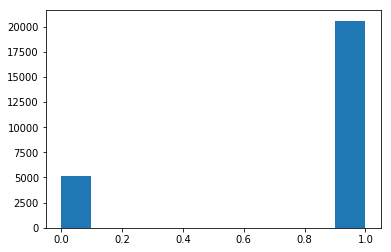

In [13]:
#len(validation_acc)
plt.hist(validation_acc)

In [18]:
acc[0][1]

0.926964

In [15]:
validation_label_batch

array([1], dtype=int32)

In [19]:
validation_prob = []
validation_labels = []
sess.run(validation_init_op)    
while True:
    try:
        validation_features_batch,  validation_label_batch = sess.run(validation_next_batch)
        validation_labels.append(validation_label_batch[0])
    except tf.errors.OutOfRangeError:
        break
    acc = sess.run(infer_op, 
                   feed_dict={X: validation_features_batch})
    validation_prob.append(acc[0][1])

In [22]:
average_precision = average_precision_score(validation_labels, validation_prob)

precision, recall, _ = precision_recall_curve(validation_labels, validation_prob)


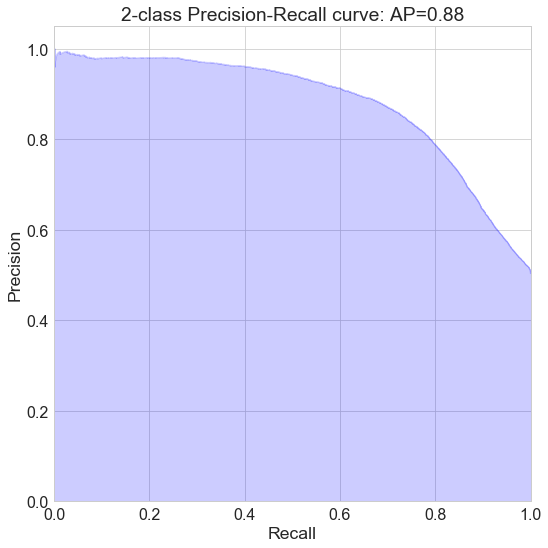

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.step(recall, precision, color='b', alpha=0.2,
         where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
fig.tight_layout()
fig.savefig('presentation_images/random_forest_PRAUC.pdf')

# Patch stuff

In [28]:
wsi = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_005.tif'
json_filepath = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/lesion_annotations_json/tumor_005.json'
savedir = '/Z/personal-folders/interns/saket/github/pywsi/data/wsi_heatmap_rf/'
os.makedirs(savedir, exist_ok=True)
img_mask_dir = '/Z/personal-folders/interns/saket/github/pywsi/data/patch_img_and_mask/'
basename = path_leaf(wsi).replace('.tif', '')
#if basename!= 'tumor_110':
#    continue
patchsize = 256
saveto = os.path.join(savedir, basename + '.joblib.pickle')
saveto_original = os.path.join(savedir,
                               basename + '.original.joblib.pickle')

all_samples =  pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/tumor_005.tsv')
if 'img_path' not in all_samples.columns:
    assert img_mask_dir is not None, 'Need to provide directory if img_path column is missing'
    tile_loc = all_samples.tile_loc.astype(str)
    tile_loc = tile_loc.str.replace(' ', '').str.replace(
        ')', '').str.replace('(', '')

    all_samples[['row', 'col']] = tile_loc.str.split(',', expand=True)
    all_samples['img_path'] = img_mask_dir + '/' + all_samples[[
        'uid', 'row', 'col'
    ]].apply(
        lambda x: '_'.join(x.values.tolist()),
        axis=1) + '.img.joblib.pickle'

    all_samples['mask_path'] = img_mask_dir + '/' + all_samples[[
        'uid', 'row', 'col'
    ]].apply(
        lambda x: '_'.join(x.values.tolist()),
        axis=1) + '.mask.joblib.pickle'
    
if not os.path.isfile('/tmp/white.img.pickle'):
    white_img = np.ones(
        [patchsize, patchsize, 3], dtype=np.uint8) * 255
    joblib.dump(white_img, '/tmp/white.img.pickle')

# Definitely not a tumor and hence all black
if not os.path.isfile('/tmp/white.mask.pickle'):
    white_img_mask = np.ones(
        [patchsize, patchsize], dtype=np.uint8) * 0
    joblib.dump(white_img_mask, '/tmp/white.mask.pickle')

all_samples.loc[all_samples.is_tissue == False,
                'img_path'] = '/tmp/white.img.pickle'
all_samples.loc[all_samples.is_tissue == False,
                'mask_path'] = '/tmp/white.mask.pickle'
for idx, row in all_samples.iterrows():
    f = row['img_path']
    if not os.path.isfile(f):
        row['savedir'] = img_mask_dir
        row['patch_size'] = patchsize
        row['index'] = idx
        save_images_and_mask(row)
print(all_samples.head())

   is_tissue  is_tumor        uid  \
0      False     False  tumor_005   
1      False     False  tumor_005   
2      False     False  tumor_005   
3      False     False  tumor_005   
4      False     False  tumor_005   

                                          slide_path  \
0  /Z/personal-folders/interns/saket/histopath_da...   
1  /Z/personal-folders/interns/saket/histopath_da...   
2  /Z/personal-folders/interns/saket/histopath_da...   
3  /Z/personal-folders/interns/saket/histopath_da...   
4  /Z/personal-folders/interns/saket/histopath_da...   

                                       json_filepath tile_loc row col  \
0  /Z/personal-folders/interns/saket/histopath_da...   (0, 0)   0   0   
1  /Z/personal-folders/interns/saket/histopath_da...   (0, 1)   0   1   
2  /Z/personal-folders/interns/saket/histopath_da...   (0, 2)   0   2   
3  /Z/personal-folders/interns/saket/histopath_da...   (0, 3)   0   3   
4  /Z/personal-folders/interns/saket/histopath_da...   (0, 4)   0   4   

 

In [ ]:
all_samples.to_csv('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/tumor_005_with_mask.tsv',
                  index=False,
                  header=True, sep='\t')

In [ ]:
testing_init_op, testing_next_batch =  input_fn(['/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/tumor_005_with_mask_segmented.tsv'],
                                                batch_size)


In [29]:
tumor005_segdf = pd.read_table('/Z/personal-folders/interns/saket/github/pywsi/data/patch_df/tumor_005_segmented.fixed.segmented.tsv')
tumor005_segdf.head()

,is_tissue,is_tumor,uid,slide_path,json_filepath,tile_loc,row,col,img_path,mask_path,savedir,patch_size,segmented_png,segmented_tsv
0,False,False,tumor_005,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(0, 0)",0,0,/tmp/white.img.pickle,/tmp/white.mask.pickle,data/patch_segmented_tumor005,256,NaN,NaN
1,False,False,tumor_005,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(0, 1)",0,1,/tmp/white.img.pickle,/tmp/white.mask.pickle,data/patch_segmented_tumor005,256,NaN,NaN
2,False,False,tumor_005,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(0, 2)",0,2,/tmp/white.img.pickle,/tmp/white.mask.pickle,data/patch_segmented_tumor005,256,NaN,NaN
3,False,False,tumor_005,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(0, 3)",0,3,/tmp/white.img.pickle,/tmp/white.mask.pickle,data/patch_segmented_tumor005,256,NaN,NaN
4,False,False,tumor_005,/Z/personal-folders/interns/saket/histopath_da...,/Z/personal-folders/interns/saket/histopath_da...,"(0, 4)",0,4,/tmp/white.img.pickle,/tmp/white.mask.pickle,data/patch_segmented_tumor005,256,NaN,NaN


In [30]:
n_samples = len(tumor005_segdf.index)
n_samples

327756

In [32]:
slide = WSIReader(wsi, 40)
n_cols = int(slide.dimensions[0] / patchsize)
n_rows = int(slide.dimensions[1] / patchsize)
assert n_rows * n_cols == n_samples, 'Some division error;'
print('Total: {}'.format(n_samples))


Total: 327756


In [33]:
"""
def generate_rows(samples, num_samples, batch_size=32):
    while True:  # Loop forever so the generator never terminates        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset + batch_size]
            is_tissue = batch_samples.is_tissue.tolist()
            is_tumor = batch_samples.is_tumor.astype('int32').tolist()
            features = []            
            batch_samples = batch_samples.copy().drop(columns=['is_tissue', 'is_tumor'])
            for _, batch_sample in batch_samples.iterrows():
                row = batch_samples.values                
                features.append(row)                
            X_train = np.array(features)
            y_train = np.array(labels)
            
            yield X_train, y_train
"""
def generate_rows(samples, num_samples, batch_size=1):
    while True:  # Loop forever so the generator never terminates        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset + batch_size]
            #is_tissue = batch_samples.is_tissue.tolist()
            #is_tumor = batch_samples.is_tumor.astype('int32').tolist()
            features = []            
            labels = []
            #batch_samples = batch_samples.copy().drop(columns=['is_tissue', 'is_tumor'])
            for _, batch_sample in batch_samples.iterrows():
                row = batch_sample.values                
                label = int(batch_sample.is_tumor)
                if batch_sample.is_tissue:
                    feature = pd.read_table(os.path.join('/Z/personal-folders/interns/saket/github/pywsi', batch_sample.segmented_tsv))
                    feature = feature.drop(columns=['is_tumor', 'is_tissue'])
                    assert len(feature.columns) == 46
                    features.append(feature.loc[0].values)  
                else:
                    values = [0.0]*46
                    features.append(values)  
                labels.append(label)
            X_train = np.array(features, dtype=np.float32)
            y_train = np.array(labels)
            #print(X_train)
            #print(y_train)
            yield X_train,  y_train

In [55]:
predicted_thumbnails = list()
batch_size = 1
"""
sess.run(testing_init_op)    
while True:
    try:
        testing_features_batch,  testing_label_batch = sess.run(testing_next_batch)
    except tf.errors.OutOfRangeError:
        break
    preds = sess.run(infer_op, 
                   feed_dict={X: testing_features_batch})
    predicted_thumbnails.append(preds)
""" 
true_labels = []
for offset in tqdm_notebook(list(range(0, n_samples, batch_size))):
    batch_samples = tumor005_segdf.iloc[offset:offset + batch_size]
    X_test, true_label = next(
        generate_rows(batch_samples, batch_size))
    true_labels.append(true_label)
    if batch_samples.is_tissue.nunique(
    ) == 1 and batch_samples.iloc[0].is_tissue == False:
        # all patches in this row do not have tissue, skip them all
        #predicted_thumbnails.append(
        #    np.zeros(batch_size, dtype=np.float32))
        predicted_thumbnails.append(0)
    else:
        preds = sess.run(infer_op, 
                          feed_dict={X: X_test})
        predicted_thumbnails.append(preds[0][1])
predicted_thumbnails = np.asarray(predicted_thumbnails)

In [56]:
savedir = '/Z/personal-folders/interns/saket/github/pywsi/data/wsi_heatmap_rf'
saveto = os.path.join(savedir, 'tumor_005.job.pickle')
os.makedirs(savedir, exist_ok=True)
output_thumbnail_preds = predicted_thumbnails.reshape(
                n_rows, n_cols)

joblib.dump(output_thumbnail_preds, saveto)

['/Z/personal-folders/interns/saket/github/pywsi/data/wsi_heatmap_rf/tumor_005.job.pickle']

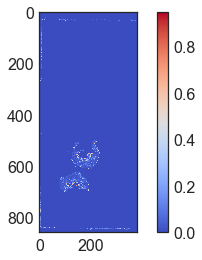

In [61]:
fig, ax = plt.subplots()
sns.set_style('white')
x = ax.imshow(output_thumbnail_preds, cmap='coolwarm')
plt.colorbar(x)
fig.tight_layout()


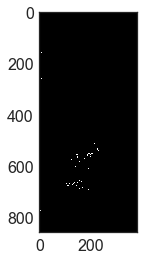

In [64]:
fig, ax = plt.subplots()
sns.set_style('white')
x = ax.imshow(output_thumbnail_preds > 0.5, cmap='gray')
#plt.colorbar(x)
fig.tight_layout()
